In [8]:
!nvidia-smi

Sun May 14 22:49:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |    255MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!python -m pip install "dask[complete]"    # Install everything
!python -m pip install "dask-ml[complete]"    # Install everything
#!pip install dask
!pip install dask-ml
#!pip install tune-sklearn "ray[tune]"
!pip install bokeh

In [10]:
!pip -q install --upgrade numpy pandas scipy sklearn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
ydata-profiling 4.1.2 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
ydata-profiling 4.1.2 requires pandas!=1.4.0,<1.6,>1.1, but you have pandas 2.0.1 which is incompatible.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
woodwork 0.23.0 requires pandas<2.0.0,>=1.4.3, but you have pandas 2.0.1 which is incompatible.
wfdb 4.1.0 requires pandas<2.0.0,>=1.0.0, but you have pandas 2.0.1 which is incompatible.
tpot 0.11.7 requires xgboost>=1.1.0, but you have xgboost 0.90 which is incompatible.
tensorflow 2.

In [11]:
!pip -q install numpy==1.23.5
!pip -q install pandas==1.5.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
ydata-profiling 4.1.2 requires pandas!=1.4.0,<1.6,>1.1, but you have pandas 2.0.1 which is incompatible.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
woodwork 0.23.0 requires pandas<2.0.0,>=1.4.3, but you have pandas 2.0.1 which is incompatible.
wfdb 4.1.0 requires pandas<2.0.0,>=1.0.0, but you have pandas 2.0.1 which is incompatible.
tpot 0.11.7 requires xgboost>=1.1.0, but you have xgboost 0.90 which is incompatible.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-s

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra"
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resized-image/froggo_32x32.png
/kaggle/input/test-2/froggo2.png
/kaggle/input/test-2/froggo2_32x32.png
/kaggle/input/vgg16-cifake/REAL_Test_Features.csv
/kaggle/input/vgg16-cifake/Fake_Train_Features.csv
/kaggle/input/vgg16-cifake/Fake_Test_Features.csv
/kaggle/input/vgg16-cifake/Real_Train_Features.csv
/kaggle/input/live-demo/froggo.png


In [13]:
import cudf
from cuml.svm import SVC
#from sklearn.svm import SVC
import seaborn as sns
import dask
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask.distributed import LocalCluster
import dask.dataframe as dd
from dask.utils import parse_bytes
#from tune_sklearn import TuneGridSearchCV
from dask_ml.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from time import time


## Functions to load data from Kaggle

In [14]:
def train_data_vgg16(sample_size=1.0):
    df_real = pd.read_csv("/kaggle/input/vgg16-cifake/Real_Train_Features.csv")
    df_fake = pd.read_csv("/kaggle/input/vgg16-cifake/Fake_Train_Features.csv")
    df = pd.concat([df_real,df_fake],axis=0).drop('Unnamed: 0', axis=1)
    
    df_sample = df.sample(frac=sample_size, random_state=0)
    
    X = df_sample.drop('class', axis=1)
    
    le = LabelEncoder()
    y = df_sample['class']
    y = pd.DataFrame(le.fit_transform(y), columns=['class'])  # encode y to be numeric
    
    return (X, y)

def test_data_vgg16():
    df_real = pd.read_csv("/kaggle/input/vgg16-cifake/REAL_Test_Features.csv")
    df_fake = pd.read_csv("/kaggle/input/vgg16-cifake/Fake_Test_Features.csv")
    
    df = pd.concat([df_real,df_fake],axis=0).drop('Unnamed: 0', axis=1)
    X = df.drop('class', axis=1)
    
    le = LabelEncoder()
    y = df['class']
    y = pd.DataFrame(le.fit_transform(y), columns=['class'])  # encode y to be numeric
    
    return (X, y)

In [15]:
X, y = train_data_vgg16(sample_size=1.0)
X.head(3)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
3582,0.000000,0.0,0.0,0.000000,4.260871,18.161793,0.0,0.000000,0.0,20.675310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10498,32.219925,0.0,0.0,24.435274,0.000000,0.000000,0.0,2.313794,0.0,10.794803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3227,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.122879


In [16]:
stnd = StandardScaler()
stnd.fit(X)
X = pd.DataFrame(stnd.transform(X), columns = X.columns)

## We need to use the Dask library to actually use the GPU

In [17]:
X_dask = dd.from_pandas(X, npartitions=1)
y_dask = dd.from_pandas(y, npartitions=1)

In [18]:
grid = {
            'C': np.arange(1, 13, .5),
            'gamma': np.arange(.0012, .0033, .0003)
        }
svm = SVC(kernel='rbf')
svmCV = GridSearchCV(svm, grid, return_train_score=True)

## Run grid search on the GPU

In [19]:
cluster = LocalCluster(n_workers=1,memory_limit='14GB',dashboard_address=None)
client = Client(cluster)

with cluster:
    with Client(cluster) as client:
        time_start = time()
        svmCV.fit(X_dask, y_dask)
        time_stop = time()
        print(f"Time elapsed: {(time_stop - time_start) / 60.0:.2f} minutes")

client.close()
cluster.close()

2023-05-14 22:51:43,841 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 14GB due to system memory limit of 13.00 GiB
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Time elapsed: 136.34 minutes


In [20]:
svmCV.best_score_

0.9046699979639053

In [21]:
svmCV.best_params_

{'C': 3.5, 'gamma': 0.0020999999999999994}

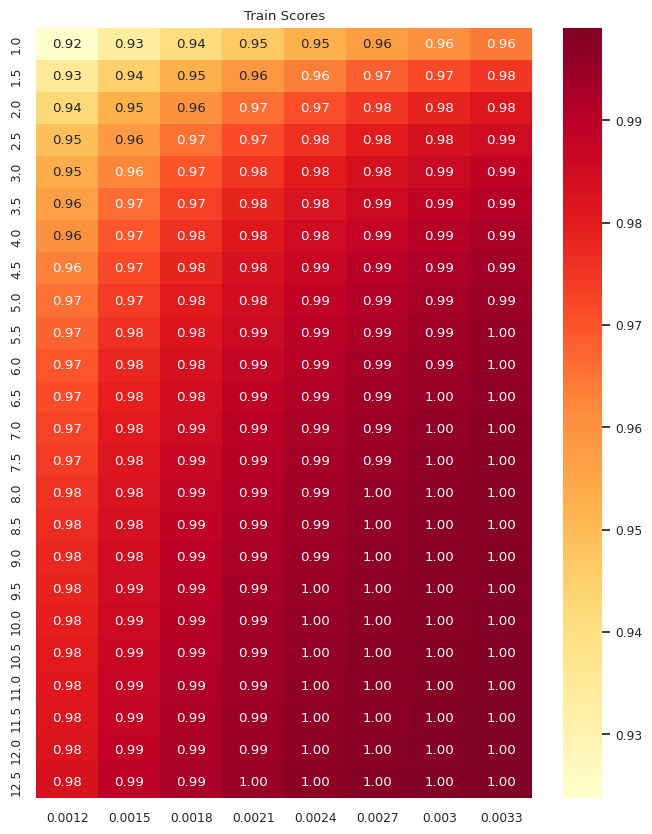

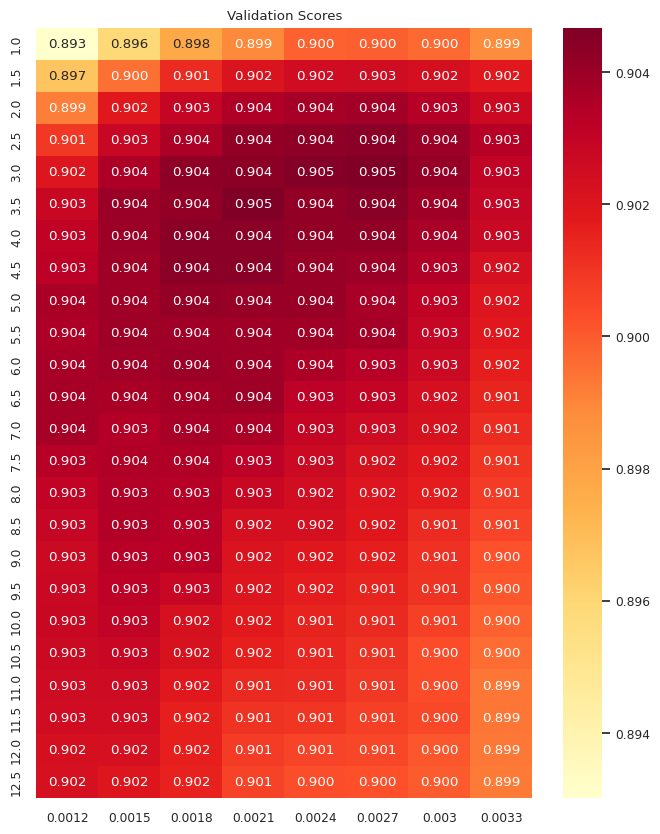

In [28]:
# Extract the hyperparameters, scores, and create a results dataframe
results = pd.DataFrame(svmCV.cv_results_)
gamma = np.around([float(x) for x in results['param_gamma'].unique()], decimals=4)
C = results['param_C'].unique()
train = np.array(results['mean_train_score']).reshape(len(C), len(gamma))
valid = np.array(results['mean_test_score']).reshape(len(C), len(gamma))

# Create a heatmap of the results
sns.set(style='whitegrid', font_scale=.8)
fig, ax = plt.subplots(figsize=(8, 10))
ax.set(xlabel='Gamma', ylabel='C', title='Train Scores')
sns.heatmap(train, annot=True, fmt='.2f', cmap='YlOrRd', xticklabels=gamma, yticklabels=C)
plt.show()

sns.set(style='whitegrid', font_scale=.8)
fig, ax = plt.subplots(figsize=(8, 10))
ax.set(xlabel='Gamma', ylabel='C', title='Validation Scores')
sns.heatmap(valid, annot=True, fmt='.3f', cmap='YlOrRd', xticklabels=gamma, yticklabels=C)
plt.show()

In [23]:
X_test, y_test = test_data_vgg16()

In [24]:
X_test = pd.DataFrame(stnd.transform(X_test), columns = X_test.columns)

In [25]:
c = svmCV.best_params_['C']
g = svmCV.best_params_['gamma']

### For whatever reason we couldn't use .best_estimator_ so we just retrained the best model

In [26]:
cluster = LocalCluster(n_workers=1,memory_limit='14GB',dashboard_address=None)
client = Client(cluster)

with cluster:
    with Client(cluster) as client:
        time_start = time()
        
        svmTest = SVC(C=c, gamma=g, kernel='rbf')
        svmTest.fit(X, y)
        print('Test score: ', svmTest.score(X_test, y_test))
        
        time_stop = time()
        print(f"Time elapsed: {(time_stop - time_start) / 60.0:.2f} minutes")

client.close()
cluster.close()

2023-05-15 01:08:12,109 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 14GB due to system memory limit of 13.00 GiB


Test score:  0.9103999733924866
Time elapsed: 0.46 minutes


## Confusion Matrix

In [30]:
df_real = pd.read_csv("/kaggle/input/vgg16-cifake/REAL_Test_Features.csv")
df_fake = pd.read_csv("/kaggle/input/vgg16-cifake/Fake_Test_Features.csv")
df_test = pd.concat([df_real,df_fake],axis=0).drop('Unnamed: 0', axis=1)

y_test = df_test['class']

In [36]:
prediction = svmTest.predict(X_test)

le = LabelEncoder()
le.fit(y_test)
prediction = le.inverse_transform(prediction)
prediction

array(['Real', 'Real', 'Real', ..., 'Fake', 'Fake', 'Fake'], dtype=object)

In [37]:
confusion = pd.DataFrame()
confusion['target'] = y_test
confusion['prediction'] = prediction
confusion.head()

,target,prediction
0,Real,Real
1,Real,Real
2,Real,Real
3,Real,Real
4,Real,Real


In [38]:
# True Positive = Real Real
# False Positive = Fake Real
# True Negative = Fake Fake
# False Negative = Real Fake
confusion.value_counts()

target  prediction
Fake    Fake          9104
Real    Real          9104
Fake    Real           896
Real    Fake           896
dtype: int64